### Setting things up

In [ ]:
!pip install transformers==4.49.0 -q
!pip install git+https://github.com/autodistill/autodistill-grounded-sam-2 rf_groundingdino -q
!pip install roboflow -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 104.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4

In [ ]:
import os
from google.colab import userdata
from autodistill_grounded_sam_2 import GroundedSAM2
from autodistill.detection import CaptionOntology
from autodistill.utils import plot
import cv2
import supervision as sv
from roboflow import Roboflow
import shutil

#use your own api & workspace ID
rf = Roboflow(api_key=userdata.get('robo_api'))
workspace = rf.workspace("vision-works")



Importing from timm.models.layers is deprecated, please import via timm.layers


loading Roboflow workspace...


In [ ]:

os.environ["KAGGLE_KEY"] = userdata.get('kaggle_key') #use your own api & ID
os.environ["KAGGLE_USERNAME"] = userdata.get('kaggle_id')

In [ ]:
# for the mixed annotation use hasnatabdullah/ulhrdie
# for individual annotation use hasnatabdullah/fldhrhdie
# you can use you own dataset here

!kaggle datasets download -d hasnatabdullah/ulhrdie

Dataset URL: https://www.kaggle.com/datasets/hasnatabdullah/ulhrdie
License(s): CC0-1.0
 99% 1.60G/1.62G [00:14<00:00, 238MB/s]
100% 1.62G/1.62G [00:15<00:00, 115MB/s]


In [ ]:
!unzip -q ulhrdie.zip > /dev/null


In [ ]:
def img_scanner(src_dir, ext=".jpg"):
    """
    Scan src_dir for images. If corrupted files exist,
    create a _clean folder with only valid ones.
    Returns the path to the folder that should be used for labeling.
    """
    skipped = []
    valid_images = []

    # scan for valid files
    for f in os.listdir(src_dir):
        fpath = os.path.join(src_dir, f)
        if not f.lower().endswith(ext.lower()):
            continue
        if not os.path.isfile(fpath):
            continue

        img = cv2.imread(fpath)
        if img is None:
            skipped.append(fpath)
            continue

        valid_images.append(fpath)

    # if no corrupted images → return original folder
    if not skipped:
        print("✅ No corrupted images found.")
        return src_dir

    # otherwise → create a clean folder
    clean_dir = src_dir.rstrip("/\\") + "_clean"
    if os.path.exists(clean_dir):
        shutil.rmtree(clean_dir)
    os.makedirs(clean_dir, exist_ok=True)

    for fpath in valid_images:
        shutil.copy(fpath, clean_dir)

    print(f"⚠️ Found {len(skipped)} corrupted images.")
    print(f"✅ Copied {len(valid_images)} valid images to {clean_dir}")

    return clean_dir

### Labeling & pushing to Roboflow

#### helmet

In [ ]:
#setting the auto-labing stuffs

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a construction hat or hard hat": "construction_hat"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
results = base_model.predict("/content/content/for_label/helmet/helmet_bing_construction_hat_000017.jpg")

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


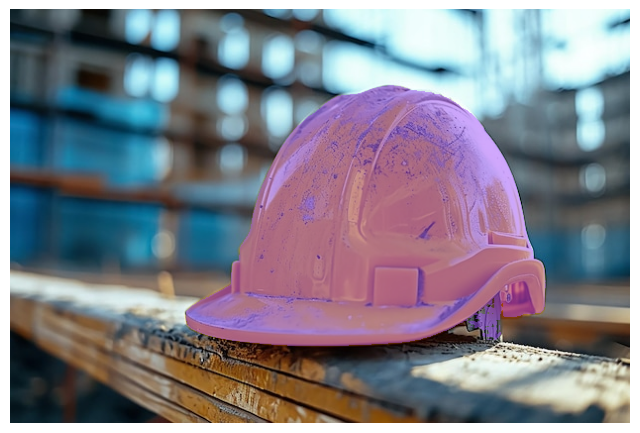

In [ ]:
image = cv2.imread("/content/content/for_label/helmet/helmet_bing_construction_hat_000017.jpg")

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
img_dir = '/content/content/for_label/helmet'

In [ ]:
base_model.label(img_dir, extension="jpg")

Labeling /content/content/for_label/helmet/helmet_duck_safety_helmet_000177.jpg: 100%|██████████| 785/785 [12:13<00:00,  1.07it/s]


Labeled dataset created - ready for distillation.


In [ ]:
#uploading to Roboflow
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/helmet_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/helmet_labeled/train/images/helmet_bing_construction_hat_000017.jpg (D0OYpwm2nZeTQAuOz7gQ) [1.3s] / annotations = OK [0.8s]
[UPLOADED] /content/content/for_label/helmet_labeled/train/images/helmet_bing_construction_hat_000036.jpg (HCzpZguaUCgFtwmEl9LQ) [1.2s] / annotations = OK [0.8s]
[UPLOADED] /content/content/for_label/helmet_labeled/train/images/helmet_bing_construction_hat_000023.jpg (tmwBatyxJVQSeOQJiSgZ) [1.4s] / annotations = OK [0.8s]
[UPLOADED] /content/content/for_label/helmet_labeled/train/images/helmet_bing_construction_hat_000015.jpg (7Svy1vRvz9E8w7ermEP0) [1.8s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/helmet_labeled/train/images/helmet_bing_construction_hat_000045.jpg (eKBSWTRFBmHznfC1028z) [1.6s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/helmet_labeled/train/images/helmet_bing_construction_ha

#### vest

In [ ]:

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a construction safety vest": "vest"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

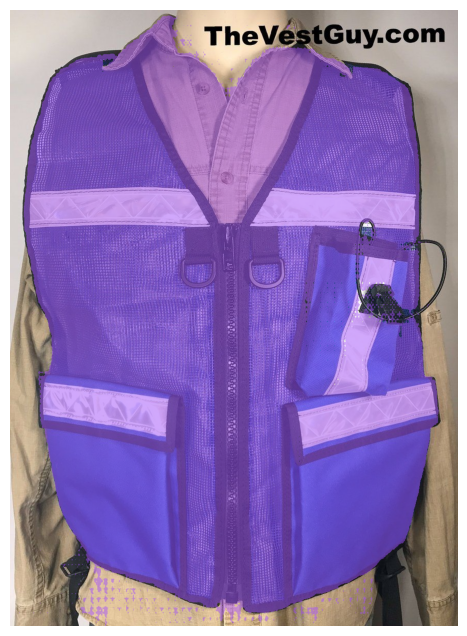

In [ ]:
test_img = '/content/content/for_label/c_vest/c_vest_bing_blue_construction_vest_000028.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
img_dir = '/content/content/for_label/c_vest'
base_model.label(img_dir, extension="jpg")

Labeling /content/content/for_label/c_vest/c_vest_bing_construction_vest_000145.jpg: 100%|██████████| 790/790 [12:00<00:00,  1.10it/s]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/c_vest_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/c_vest_labeled/train/images/c_vest_bing_blue_construction_vest_000016.jpg (82kgO9RtJjQoXWW9eLyb) [0.6s] / annotations = OK [0.3s]
[UPLOADED] /content/content/for_label/c_vest_labeled/train/images/c_vest_bing_blue_construction_vest_000019.jpg (DBaVVuy7hXakX8t4N3f2) [0.7s] / annotations = OK [0.3s]
[UPLOADED] /content/content/for_label/c_vest_labeled/train/images/c_vest_bing_blue_construction_vest_000017.jpg (Le24iwoL6XVomoRqWDpt) [0.7s] / annotations = OK [0.3s]
[UPLOADED] /content/content/for_label/c_vest_labeled/train/images/c_vest_bing_blue_construction_vest_000031.jpg (CkjVBhcxvtWZsntGQ7Bz) [0.7s] / annotations = OK [0.3s]
[UPLOADED] /content/content/for_label/c_vest_labeled/train/images/c_vest_bing_blue_construction_vest_000013.jpg (ylmywOljQ9cel80TYcLb) [0.9s] / annotations = OK [0.3s]
[UPLOADED] /content/content/for_label/c_vest_labeled/train/imag

#### boots

In [ ]:

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a construction boots": "boots"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


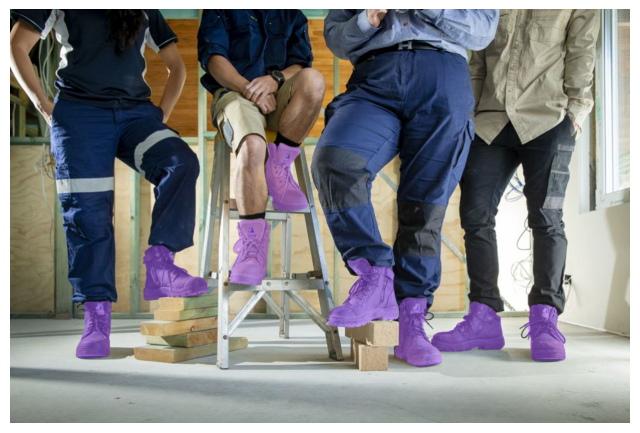

In [ ]:
test_img = '/content/content/for_label/boots/boots_bing_construction_safety_boots_000031.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
img_dir = '/content/content/for_label/boots'
base_model.label(img_dir, extension="jpg")

Labeling /content/content/for_label/boots/boots_bing_men_construction_boots_000072.jpg: 100%|██████████| 766/766 [11:39<00:00,  1.09it/s]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/boots_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/boots_labeled/train/images/boots_bing_construction_safety_boots_000015.jpg (4WkAnjkwX88F1iLIm7QT) [0.7s] / annotations = OK [0.4s]
[UPLOADED] /content/content/for_label/boots_labeled/train/images/boots_bing_construction_safety_boots_000035.jpg (yEIxDwT2nddKzB1B5RIF) [0.7s] / annotations = OK [0.4s]
[UPLOADED] /content/content/for_label/boots_labeled/train/images/boots_bing_construction_safety_boots_000028.jpg (qFtgcGLD7oaD89pOD4ng) [0.9s] / annotations = OK [0.3s]
[UPLOADED] /content/content/for_label/boots_labeled/train/images/boots_bing_construction_safety_boots_000036.jpg (JTe9ucKK80rw7K9M2zup) [0.8s] / annotations = OK [0.4s]
[UPLOADED] /content/content/for_label/boots_labeled/train/images/boots_bing_construction_safety_boots_000006.jpg (QyMIsepkQlprcNyBgkiM) [1.1s] / annotations = OK [0.4s]
[UPLOADED] /content/content/for_label/boots_labeled/train/

#### crn

In [ ]:

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a construction crane": "crane"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


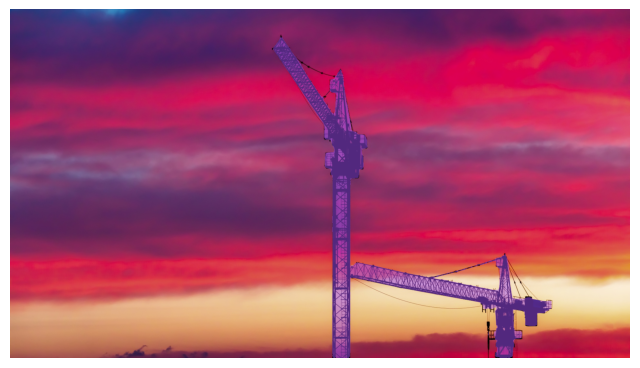

In [ ]:
test_img = '/content/content/for_label/crn/crn_bing_construction_crane_000100.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
img_dir = '/content/content/for_label/crn'
base_model.label(img_dir, extension="jpg")

Labeling /content/content/for_label/crn/crn_google_construction_truck_crane_000042.jpg: 100%|██████████| 786/786 [12:58<00:00,  1.01it/s]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/crn_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/crn_labeled/train/images/crn_bing_boom_truck_000020.jpg (Vmokl8xelxNEfyNrREdg) [1.5s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/crn_labeled/train/images/crn_bing_boom_truck_000022.jpg (1WBNcC1puEXsDvml4USR) [1.6s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/crn_labeled/train/images/crn_bing_boom_truck_000023.jpg (Nc8eIsmjRdANSwCjxgvq) [2.0s] / annotations = OK [0.8s]
[UPLOADED] /content/content/for_label/crn_labeled/train/images/crn_bing_boom_truck_000012.jpg (W9a2Nd0NHu3SSsdqQKAG) [2.5s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/crn_labeled/train/images/crn_bing_boom_truck_000010.jpg (uQOG53AL20TwXLogbxM6) [3.1s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/crn_labeled/train/images/crn_bing_boom_truck_000025.jpg (vmg9A1ytb0V3lQ2AFdaq) [3.1s] / annotations = OK [0.5s]
[UP

#### excavator

In [ ]:

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a construction excavator": "excavator"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


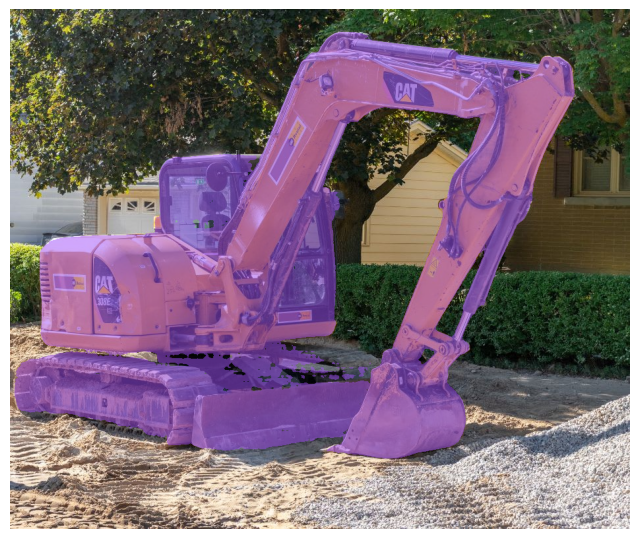

In [ ]:
test_img = '/content/content/for_label/exvtr/exvtr_bing_cat_excavator_000012.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
import os
import cv2
import shutil

src_dir = '/content/content/for_label/exvtr'
clean_dir = '/content/content/for_label/exvtr_clean'

# make clean dir fresh
if os.path.exists(clean_dir):
    shutil.rmtree(clean_dir)
os.makedirs(clean_dir, exist_ok=True)

skipped = []

# filter and copy only valid images
for f in os.listdir(src_dir):
    fpath = os.path.join(src_dir, f)
    if not f.lower().endswith(".jpg"):
        continue
    if not os.path.isfile(fpath):
        continue

    img = cv2.imread(fpath)
    if img is None:
        print(f"⚠️ Skipping corrupted/unreadable file: {fpath}")
        skipped.append(fpath)
        continue

    shutil.copy(fpath, clean_dir)

print(f"✅ Copied valid images to {clean_dir}. Skipped {len(skipped)} bad files.")



⚠️ Skipping corrupted/unreadable file: /content/content/for_label/exvtr/exvtr_bing_excavator_000169.jpg
⚠️ Skipping corrupted/unreadable file: /content/content/for_label/exvtr/exvtr_duck_cat_excavator_000024.jpg
⚠️ Skipping corrupted/unreadable file: /content/content/for_label/exvtr/exvtr_duck_excavator_000114.jpg
✅ Copied valid images to /content/content/for_label/exvtr_clean. Skipped 3 bad files.


In [ ]:
img_dir = '/content/content/for_label/exvtr_clean'
base_model.label(img_dir, extension="jpg")

Labeling /content/content/for_label/exvtr_clean/exvtr_duck_construction_excavator_000075.jpg: 100%|██████████| 793/793 [12:59<00:00,  1.02it/s]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/exvtr_clean_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/exvtr_clean_labeled/train/images/exvtr_bing_cat_excavator_000030.jpg (dlzE9ygLziGG0hgGfQMb) [1.5s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/exvtr_clean_labeled/train/images/exvtr_bing_cat_excavator_000021.jpg (M02GrQ1Q5vtau7PIrozs) [2.1s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/exvtr_clean_labeled/train/images/exvtr_bing_cat_excavator_000013.jpg (e5EoFKCVPiQ2GH55CnMd) [2.2s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/exvtr_clean_labeled/train/images/exvtr_bing_cat_excavator_000014.jpg (gNjo6NU4y1ZkLl6krlK2) [2.3s] / annotations = OK [0.7s]
[UPLOADED] /content/content/for_label/exvtr_clean_labeled/train/images/exvtr_bing_cat_excavator_000009.jpg (KIOBbSjoj3MnKsCpZpMQ) [2.6s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/exvtr_clean_labeled/train/images/exvtr_bing_cat_ex

#### gloves

In [ ]:

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a construction safety gloves": "gloves"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


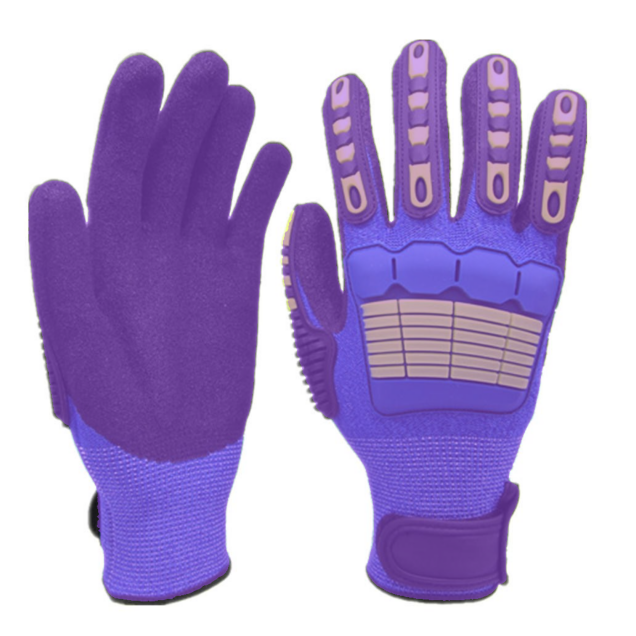

In [ ]:
test_img = '/content/content/for_label/gloves/gloves_bing_construction_gloves_000024.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
img_dir = img_scanner('/content/content/for_label/gloves')


✅ No corrupted images found.


In [ ]:
base_model.label(img_dir, extension="jpg")

Labeling /content/content/for_label/gloves/gloves_bing_construction_safety_gloves_000046.jpg: 100%|██████████| 774/774 [12:01<00:00,  1.07it/s]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/gloves_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/gloves_labeled/train/images/gloves_bing_construction_gloves_000024.jpg (QSqU7LWy9BjYPgnUwmWj) [1.6s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/gloves_labeled/train/images/gloves_bing_construction_gloves_000026.jpg (8GQHW6Jm0CPQefH6HMpP) [1.4s] / annotations = OK [0.8s]
[UPLOADED] /content/content/for_label/gloves_labeled/train/images/gloves_bing_construction_gloves_000001.jpg (d5xKUAcmTEyAognWWhPp) [2.3s] / annotations = OK [0.9s]
[UPLOADED] /content/content/for_label/gloves_labeled/train/images/gloves_bing_construction_gloves_000033.jpg (Fy8mbDF3tdyKa5kL87KP) [2.7s] / annotations = OK [0.8s]
[UPLOADED] /content/content/for_label/gloves_labeled/train/images/gloves_bing_construction_gloves_000028.jpg (2vBHxTawXb9qYSPpuhUf) [3.0s] / annotations = OK [0.7s]
[UPLOADED] /content/content/for_label/gloves_labeled/train/images/gloves_bing_

#### ladder

In [ ]:

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a construction ladder": "ladder"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


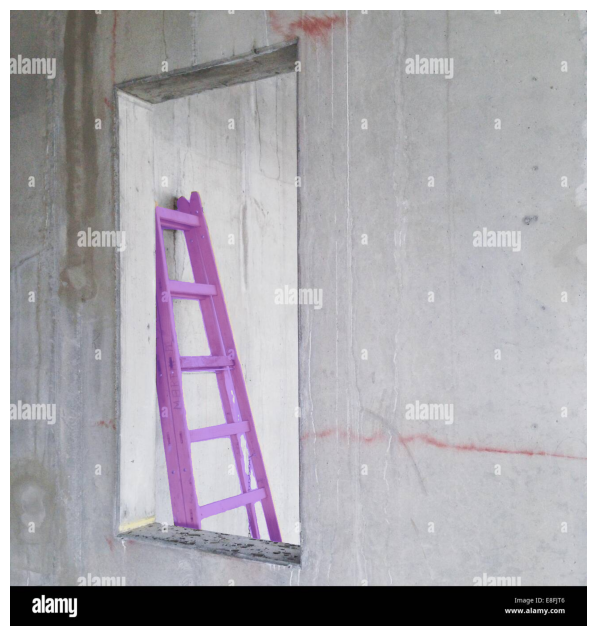

In [ ]:
test_img = '/content/content/for_label/ldr/ldr_bing_building_construction_ladder_000034.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
img_dir = img_scanner('/content/content/for_label/ldr')
base_model.label(img_dir, extension="jpg")

⚠️ Found 4 corrupted images.
✅ Copied 786 valid images to /content/content/for_label/ldr_clean


Labeling /content/content/for_label/ldr_clean/ldr_bing_building_construction_ladder_000146.jpg: 100%|██████████| 786/786 [12:20<00:00,  1.06it/s]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/ldr_clean_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/ldr_clean_labeled/train/images/ldr_bing_building_construction_ladder_000029.jpg (4A7YXHcIHPlG7VVaktlP) [1.1s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/ldr_clean_labeled/train/images/ldr_bing_building_construction_ladder_000021.jpg (OwCYvEDI4kmWwY3q2OpD) [1.5s] / annotations = OK [0.4s]
[UPLOADED] /content/content/for_label/ldr_clean_labeled/train/images/ldr_bing_building_construction_ladder_000035.jpg (WU8qyE52TrLQaRX4rLhT) [1.5s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/ldr_clean_labeled/train/images/ldr_bing_building_construction_ladder_000036.jpg (7Cth1ZhiyyhsUj645Xsi) [1.6s] / annotations = OK [0.9s]
[UPLOADED] /content/content/for_label/ldr_clean_labeled/train/images/ldr_bing_building_construction_ladder_000012.jpg (2Yibh7DLV7p9JZSvkzMW) [2.2s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_l

#### goggles

In [ ]:

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a safety goggles": "goggles"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


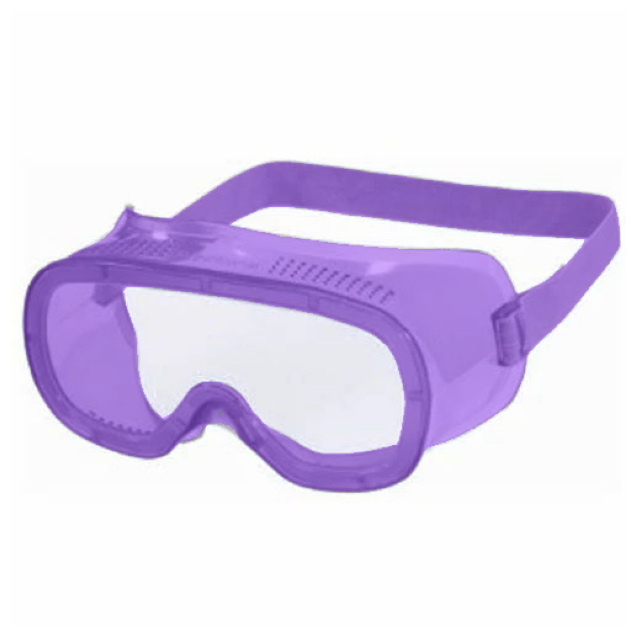

In [ ]:
test_img = '/content/content/for_label/goggles/goggles_bing_construction_goggles_000020.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
!rm -rf /content/content/for_label/goggles_labeled

In [ ]:
img_dir = img_scanner('/content/content/for_label/goggles')
base_model.label(img_dir, extension="jpg")

⚠️ Found 1 corrupted images.
✅ Copied 790 valid images to /content/content/for_label/goggles_clean


Labeling /content/content/for_label/goggles_clean/goggles_duck_construction_goggles_000004.jpg: 100%|██████████| 790/790 [12:03<00:00,  1.09it/s]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/goggles_clean_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/goggles_clean_labeled/train/images/goggles_bing_construction_goggles_000026.jpg (0NKNfTXG9xWQ4LOm3TJ0) [0.6s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/goggles_clean_labeled/train/images/goggles_bing_construction_goggles_000008.jpg (KEV2V98fgNAARrdUZiJj) [0.8s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/goggles_clean_labeled/train/images/goggles_bing_construction_goggles_000019.jpg (4ac72gNCVyQqMKoPAimE) [1.2s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/goggles_clean_labeled/train/images/goggles_bing_construction_goggles_000006.jpg (mHjzhrD39As1RQUw4UhV) [1.3s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/goggles_clean_labeled/train/images/goggles_bing_construction_goggles_000049.jpg (7ub8cjlTYlXQyUIzJ3Pk) [1.1s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_l

#### mask

In [ ]:

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a safety mask": "mask"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


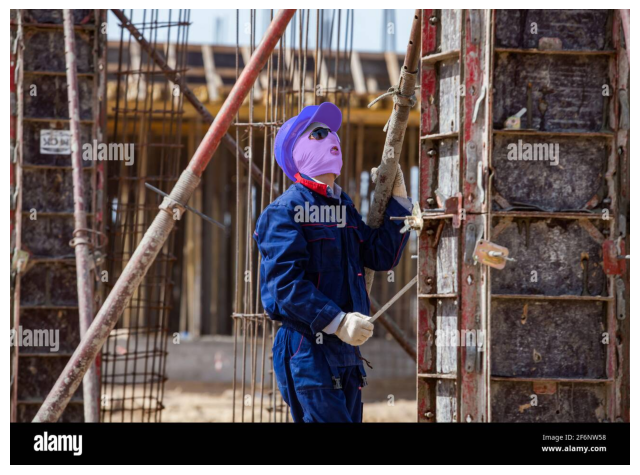

In [ ]:
test_img = '/content/content/for_label/msk/msk_bing_balaclava_construction_mask_000010.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
img_dir = img_scanner('/content/content/for_label/msk')
base_model.label(img_dir, extension="jpg")

✅ No corrupted images found.


Labeling /content/content/for_label/msk/msk_bing_balaclava_construction_mask_000264.jpg: 100%|██████████| 789/789 [11:59<00:00,  1.10it/s]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/msk_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/msk_labeled/train/images/msk_bing_balaclava_construction_mask_000008.jpg (mWLpb8pV8W1B4iwc0JUm) [1.3s] / annotations = OK [0.4s]
[UPLOADED] /content/content/for_label/msk_labeled/train/images/msk_bing_balaclava_construction_mask_000007.jpg (t39IvOumgRwHMrVKjagG) [1.5s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/msk_labeled/train/images/msk_bing_balaclava_construction_mask_000005.jpg (tgwyiHiH9waiT7bUr9Hy) [1.9s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/msk_labeled/train/images/msk_bing_balaclava_construction_mask_000033.jpg (ql4qsl5Fb82a4sDCu3Ob) [2.3s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/msk_labeled/train/images/msk_bing_balaclava_construction_mask_000018.jpg (ADeWBUXOIVCElAPaROch) [2.5s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/msk_labeled/train/images/msk_b

#### cone

In [ ]:

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a safety cone": "cone"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


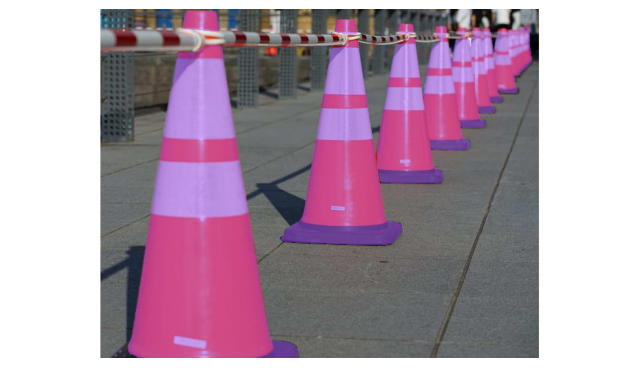

In [ ]:
test_img = '/content/content/for_label/s_cone/s_cone_bing_construction_cone_000025.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
img_dir = img_scanner('/content/content/for_label/s_cone')
base_model.label(img_dir, extension="jpg")

⚠️ Found 1 corrupted images.
✅ Copied 783 valid images to /content/content/for_label/s_cone_clean


Labeling /content/content/for_label/s_cone_clean/s_cone_google_work_safety_cone_000031.jpg: 100%|██████████| 783/783 [12:15<00:00,  1.06it/s]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/s_cone_clean_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/s_cone_clean_labeled/train/images/s_cone_bing_construction_cone_000031.jpg (sX9vPfShZohqD5WmEFz2) [1.4s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/s_cone_clean_labeled/train/images/s_cone_bing_construction_cone_000006.jpg (AdahNgffQaaqtyvnBK92) [1.5s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/s_cone_clean_labeled/train/images/s_cone_bing_construction_cone_000025.jpg (youEPXpPfQE8vtnYcUuW) [1.5s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/s_cone_clean_labeled/train/images/s_cone_bing_construction_cone_000038.jpg (9NiMJGhggqmRl2uF6GK2) [2.1s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/s_cone_clean_labeled/train/images/s_cone_bing_construction_cone_000019.jpg (8NrYY1M8fGy9MoIARv5f) [2.1s] / annotations = OK [0.8s]
[UPLOADED] /content/content/for_label/s_cone_clean_labeled

#### truck

In [ ]:

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a construction truck": "truck"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


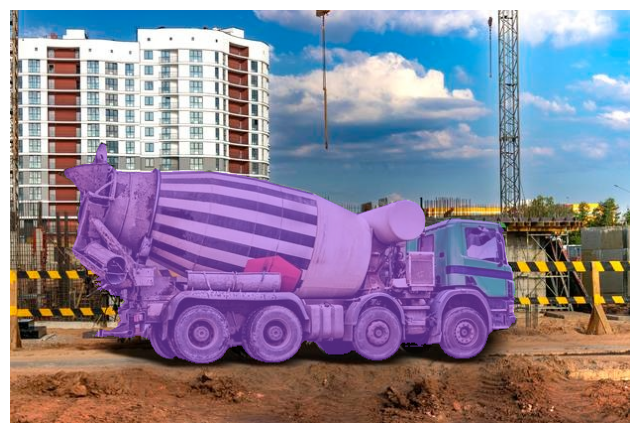

In [ ]:
test_img = '/content/content/for_label/truck/truck_bing_concrete_trucks_000011.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
img_dir = img_scanner('/content/content/for_label/truck')
base_model.label(img_dir, extension="jpg")

✅ No corrupted images found.


Labeling /content/content/for_label/truck/truck_bing_construction_transport_trucks_000261.jpg: 100%|██████████| 793/793 [12:45<00:00,  1.04it/s]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/truck_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/truck_labeled/train/images/truck_bing_concrete_trucks_000011.jpg (uJivjAHz8OdRkWVdLT4e) [1.3s] / annotations = OK [0.4s]
[UPLOADED] /content/content/for_label/truck_labeled/train/images/truck_bing_concrete_trucks_000009.jpg (SnPymc5P2LGxgrp0twxJ) [2.0s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/truck_labeled/train/images/truck_bing_concrete_trucks_000017.jpg (VfFmPRU7q8xluIOMPxrP) [2.2s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/truck_labeled/train/images/truck_bing_concrete_trucks_000022.jpg (m3nHA9jc1LPYmcQTfPTY) [2.6s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/truck_labeled/train/images/truck_bing_concrete_trucks_000015.jpg (FnjBccgD5yJlIf8YgptL) [2.8s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/truck_labeled/train/images/truck_bing_concrete_trucks_000026.jpg (rEka

#### worker

In [ ]:

base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "a construction worker": "c_worker"
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


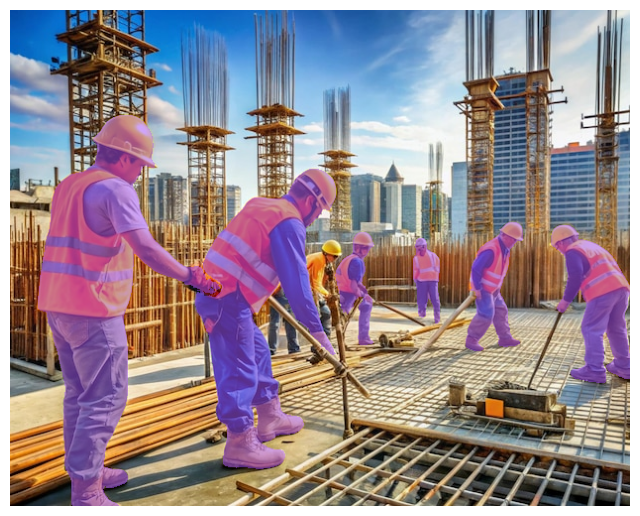

In [ ]:
test_img = '/content/content/for_label/worker/worker_bing_construction_building_worker_000019.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
img_dir = img_scanner('/content/content/for_label/worker')
base_model.label(img_dir, extension="jpg")

✅ No corrupted images found.


Labeling /content/content/for_label/worker/worker_duck_construction_building_worker_000110.jpg: 100%|██████████| 783/783 [12:46<00:00,  1.02it/s]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/for_label/worker_labeled')

loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/for_label/worker_labeled/train/images/worker_bing_construction_building_worker_000032.jpg (VyEPPWyD9q2fgeJwkMPK) [1.5s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/worker_labeled/train/images/worker_bing_construction_building_worker_000025.jpg (XkjhgmY4HZ3qirDUXdcP) [1.7s] / annotations = OK [0.8s]
[UPLOADED] /content/content/for_label/worker_labeled/train/images/worker_bing_construction_building_worker_000021.jpg (5fYrBXnzYbf6a21ddaxe) [2.5s] / annotations = OK [0.5s]
[UPLOADED] /content/content/for_label/worker_labeled/train/images/worker_bing_construction_building_worker_000030.jpg (xz9qAsHsv2lg8Bg7wG6j) [2.4s] / annotations = OK [0.6s]
[UPLOADED] /content/content/for_label/worker_labeled/train/images/worker_bing_construction_building_worker_000037.jpg (CrK2foygIUUaeqypZyyx) [2.7s] / annotations = OK [0.7s]
[UPLOADED] /content/content/for_l

#### Mixed

In [ ]:
!ls -1 /content/content/for_unlabel/worker | wc -l

723


In [ ]:
base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            " construction truck": "truck",
            " construction hat or hard hat": "construction_hat",
             " construction safety vest": "vest",
            " construction boots": "boots",
            " construction crane": "crane",
            " construction excavator": "excavator",
            " construction safety gloves": "gloves",
            " construction ladder": "ladder",
            " safety goggles": "goggles",
            " safety mask": "mask",
            " safety cone": "cone",
            " construction worker": "c_worker"

        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.60
)

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


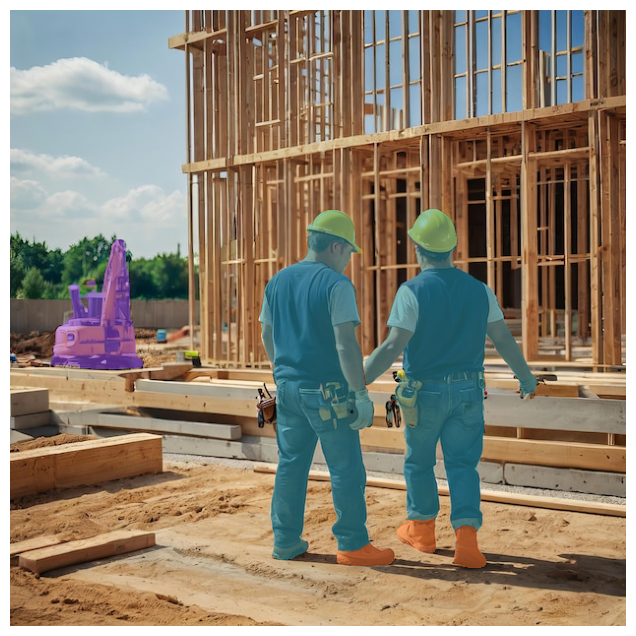

In [ ]:
test_img = '/content/content/for_unlabel/worker/worker_bing_construction_building_worker_000066.jpg'
results = base_model.predict(test_img)
image = cv2.imread(test_img)

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
img_dir = img_scanner('/content/content/worker_l_2')
base_model.label(img_dir, extension="jpg")

✅ No corrupted images found.


Labeling /content/content/worker_l_2/worker_duck_heavy_worker_000034.jpg:   0%|          | 0/348 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
Labeling /content/content/worker_l_2/worker_duck_construction_building_worker_000052.jpg: 100%|██████████| 348/348 [37:21<00:00,  6.44s/it]


Labeled dataset created - ready for distillation.


In [ ]:
workspace.upload_dataset(
project_name="cosntruction-safety-6w4xw",
dataset_path='/content/content/worker_l_2_labeled')


loading Roboflow project...
Uploading to existing project vision-works/cosntruction-safety-6w4xw
[UPLOADED] /content/content/worker_l_2_labeled/train/images/worker_bing_worker_in_construction_000077.jpg (2iiRXxxukkpssAdITIJG) [0.6s] / annotations = OK [0.3s]
[UPLOADED] /content/content/worker_l_2_labeled/train/images/worker_bing_worker_in_construction_000116.jpg (HBkTI2qbYbMdOIk6rKU5) [0.7s] / annotations = OK [0.3s]
[UPLOADED] /content/content/worker_l_2_labeled/train/images/worker_bing_worker_in_construction_000120.jpg (GryQyWKpkfb57JjBv8tx) [0.6s] / annotations = OK [0.4s]
[UPLOADED] /content/content/worker_l_2_labeled/train/images/worker_bing_worker_in_construction_000087.jpg (OhCi4x0Mh4RDnSdBE0bU) [1.0s] / annotations = OK [0.4s]
[UPLOADED] /content/content/worker_l_2_labeled/train/images/worker_bing_worker_in_construction_000091.jpg (L9j1X1LSuJ3e2eLgdzPr) [1.2s] / annotations = OK [0.4s]
[UPLOADED] /content/content/worker_l_2_labeled/train/images/worker_bing_worker_in_constructio